Goal : with our best CNN + LSTM model, evaluate the accuracy of the prediction for increasing values of similarity between founders

# Accuracy = f(similarity's mean)

First, only the mean of the 2 vs 2 similarities between founders is changed.

## Simulate founders and recombination : 1000 SNPs

In [1]:
import numpy as np
from numpy.random import choice
import random as rd
import pandas as pd
import matplotlib.pyplot as plt
import copy 
import pickle
from pprint import pprint
import copy
%matplotlib inline

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def recombine_linkage (parent_A,parent_B,linkage) :
    '''Recombines 2 parents' haplotypes at a random position chosen according to linkage'''
    r = choice(range(1,len(parent_A)),p=linkage)    # position of the recombination
    parent = rd.randint(0,1)
    child = np.copy([parent_A,parent_B][parent])
    child[r:] = [parent_A,parent_B][1-parent][r:]
    return child

def sample_parents (A) :
    '''Takes 2 parents among the individuals in a generation'''
    parent_A = rd.choice(A)
    parent_B = rd.choice(A)
    while (parent_B == parent_A).all() :
        parent_B = rd.choice(A)
    return parent_A,parent_B

def shuffle (A,G,N,p,linkage) :
    '''Recombines founders' haplotypes (p SNPs) for G generations with N individuals at each step.'''
    B=np.zeros((N,p),dtype=int)
    for k in range (N):
            (parent_A,parent_B)=sample_parents(A)                # First generation
            B[k] = recombine_linkage(parent_A,parent_B,linkage)
    A = np.copy(B)
    for g in range(1,G):
        for k in range (N):
            (parent_A,parent_B)=sample_parents(A)
            B[k] = recombine_linkage(parent_A,parent_B,linkage)
        np.copyto(A,B)
    return A

def reverse_SNPs (d_haplo,F_geno) :
    '''Converts an array of SNPs from haplotype to genotype.'''
    g = np.copy(d_haplo)
    for individual in g:
        for k in range (p):
            assert type(individual[k]-1)==np.int64, individual[k]
            individual[k]=F_geno[individual[k]-1][k]
    return g

In [291]:
def iterate_and_save_similarity (n,p,G,N,I,S,F_haplo,F_geno,linkage) :
    '''Simulates crossbreedings and saves the resulting genotypes (SNPs) + haplotypes in 2 binary files. '''
    haplo = np.zeros((n+N*I,p),dtype=int)
    haplo[:n] = F_haplo[:]
    geno = np.zeros((n+N*I,p),dtype=int)
    geno[:n] = F_geno[:]
    A = np.copy(F_haplo)
    for i in range (0,I):
        d_haplo = shuffle (A,G,N,p,linkage)
        haplo[n+i*N:n+(i+1)*N] = d_haplo                               # Add haplotypes of descentants (RILs)
        geno[n+i*N:n+(i+1)*N] = reverse_SNPs(d_haplo,F_geno)     # Add the conversion into genotypes
        if i//10==i/10 :
            print ("Iteration {0}/{1}".format(i,I))
    assert (F_haplo==np.array([[j for k in range(p)] for j in range(1,n+1)])).all(), F_haplo
    assert 0 not in d_haplo
    with open("Simulations_haplotypes_n{0}_p{1}_G{2}_N{3}_I{4}_S{5:.2f}.pkl".format(n,p,G,N,I,S),"wb") as handler:
        pickle.dump(haplo.tolist(),handler)   # Lists take much less space
    with open("Simulations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}_S{5:.2f}.pkl".format(n,p,G,N,I,S),"wb") as handler:
        pickle.dump(geno.tolist(),handler)

Résulting files :
   - Genotypes 1,0,1,0,1, ... ,1,0,1,0,0 =  
`[[[founder 1], ... , [founder 16]], [[[it 1 ind 1], ... ,[it 1 ind N]], ... ,[[it I ind 1], ... ,[it I ind N]]]`,
   - Haplotypes 3,3,3,12,12, ... ,1,1,1,1,1 =  
`[[[1,1,1,1,1,1], ... , [16,16,16,16,16,16]][[[1,1], ... ,[1,N]], ... ,[[I,1], ... ,[I,N]]]]`

In [71]:
n = 16    # number of founders
p = 1000  # nb of SNPs
G = 20    # nb of generations
N = 100   # nb of recombining individuals in a generation after sampling
I = 100   # nb of itérations

L_S = 20    # nb of intervals between similarity samplings for simulations
S_range = np.linspace(0,1,L_S+1)   # Similarity between founders

linkage = np.array([1/(p-1) for k in range(p)])   # Uniform probability of recombination

In [204]:
def simulate_founders_similarity (p,n,S) :
    return np.random.choice([0,1],size=(n,p),p=[0.5+np.sqrt(S)/2,0.5-np.sqrt(S)/2])

simulate_founders_similarity (10,5,0.6)

array([[1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [292]:
for S in S_range :
    print ("S : {0}/{1}".format(S*L,L))
    F_haplo = np.array([[j for i in range(p)] for j in range(1,n+1)])    # initial array (n founders and p SNPs)
    F_geno = simulate_founders_similarity (p,n,S)
    iterate_and_save_similarity (n,p,G,N,I,S,F_haplo,F_geno,linkage)

S : 0.0/1
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
S : 0.05/1
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
S : 0.1/1
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
S : 0.15000000000000002/1
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
S : 0.2/1
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
S : 0.25/1
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 

In [286]:
def normalized_cross_similarity (array) :
    A = np.dot(array,array.T)+np.dot(1-array,1-array.T)
    return max(0.,(np.sum(A)-np.trace(A))/((n-1)*n*p)*2-1)

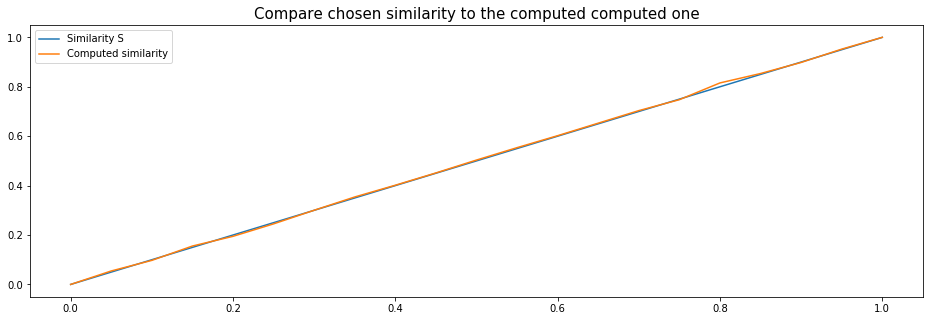

In [205]:
im, ax = plt.subplots(1,1,figsize = (16,5))
ax.plot(S_range,S_range, label = "Similarity S")
ax.plot(S_range,[normalized_cross_similarity(F_geno,n,p) for F_geno in [simulate_founders_similarity (p,n,S) for S in S_range]], label = "Computed similarity")
ax.set(title = "Compare chosen similarity to the computed computed one")
ax.legend()
plt.show()

In [293]:
for S in S_range :
    haplotypes = []
    F_haplotypes = []
    d_haplotypes = []
    with open("Simulations_1/Simulations_haplotypes_n{0}_p{1}_G{2}_N{3}_I{4}_S{5:.2f}.pkl".format(n,p,G,N,I,S),"rb") as handler:
        haplo = pickle.load(handler)
        F_haplotypes.append(np.array(haplo[:n]))
        d_haplotypes.append(np.array(haplo[n:]))

In [294]:
for S in S_range :
    genotypes = []
    F_genotypes = []
    d_genotypes = []
    with open("Simulations_1/Simulations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}_S{5:.2f}.pkl".format(n,p,G,N,I,S),"rb") as handler:
        haplo = pickle.load(handler)
        F_genotypes.append(np.array(haplo[:n]))
        d_genotypes.append(np.array(haplo[n:]))

In [13]:
print(F_haplotypes[0].shape,d_haplotypes[0].shape,F_genotypes[0].shape,d_genotypes[0].shape)

(16, 1000) (10000, 1000) (16, 1000) (10000, 1000)


## Make predictions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM, TimeDistributed, Bidirectional
from keras.layers import Conv1D, Conv2D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils, plot_model
import pickle
%matplotlib inline

/Users/jeje/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
n = 16    # number of founders
p = 1000  # nb of SNPs
G = 20    # nb of generations
N = 100   # nb of recombining individuals in a generation after sampling
I = 100   # nb of itérations

L_S = 20    # nb of intervals between similarity samplings for simulations
S_range = np.linspace(0,1,L_S+1)   # Similarity between founders

linkage = np.array([1/(p-1) for k in range(p)])   # Uniform probability of recombination

**Import simulations** : genotypes and haplotypes, F = founders, d = descendants

In [3]:
haplotypes = []
F_haplotypes = []
d_haplotypes = []
for S in S_range :
    with open("Simulations/Simulations_haplotypes_n{0}_p{1}_G{2}_N{3}_I{4}_S{5:.2f}.pkl".format(n,p,G,N,I,S),"rb") as handler:
        haplo = pickle.load(handler)
        F_haplotypes.append(np.array(haplo[:n]))
        d_haplotypes.append(np.array(haplo[n:]))
        
genotypes = []
F_genotypes = []
d_genotypes = []
for S in S_range :
    with open("Simulations/Simulations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}_S{5:.2f}.pkl".format(n,p,G,N,I,S),"rb") as handler:
        haplo = pickle.load(handler)
        F_genotypes.append(np.array(haplo[:n]))
        d_genotypes.append(np.array(haplo[n:]))

print(len(d_genotypes), F_haplotypes[0].shape, d_haplotypes[0].shape, F_genotypes[0].shape, d_genotypes[0].shape, linkage.shape)

21 (16, 1000) (10000, 1000) (16, 1000) (10000, 1000) (1000,)


In [4]:
def normalized_cross_similarity (array,n,p) :
    A = np.dot(array,array.T)+np.dot(1-array,1-array.T)
    B = A[np.triu_indices(n, k=1)]/p     # Extract the values that are above the diagonal
    return np.round(np.mean(B)*2-1,3)    # Normalize between 0 and 1

**Calculate the similarity** between the simulated founders

In [5]:
S_range_computed = []
for F_geno in F_genotypes :
    S_range_computed.append(normalized_cross_similarity(F_geno,n,p))

**Input genotypes** : creating an "image" with the descendant x17 alterning with the 16 founders and the linkage.

In [6]:
def chromosome_alternate_inputs_5 (array, F_geno, linkage, n):
    A = np.zeros((array.shape[0],array.shape[1],3*n+1))
    for k in range(len(array)) :
        individual = array[k]
        a = individual[:, np.newaxis]
        for l in range(len(F_geno)) :
            a=np.concatenate([a,F_geno[l:l+1].T, linkage[:, np.newaxis], individual[:, np.newaxis]], axis = 1)
        A[k]=a
    return A

**Output haplotypes** in 2 SNPs-long segments.

In [7]:
def chromosome_segments_output (array):
    A = np.zeros((len(array),len(array[0])//2,16))
    for k in range(len(array)) :
        individual = array[k]
        A[k] = np.array([np_utils.to_categorical(segment[1]-1,16) for segment in np.reshape(individual[:len(individual)//2*2],(-1,2))])
    return A

In [8]:
def prepare_data (d_geno, d_haplo, F_geno, linkage, n) :
    xtrain = d_geno[:3*I*N//4]
    ytrain = d_haplo[:3*I*N//4]
    xtest = d_geno[3*I*N//4:]
    ytest = d_haplo[3*I*N//4:]
    
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,3))
    ax1.imshow(xtrain, aspect = 0.01)
    ax1.set(ylabel = "Genotypes", title = "Real genotypes and haplotypes for chromosomes from the training set")
    ax2.imshow(ytrain, aspect = 0.01)
    ax2.set(ylabel = "Haplotypes", xlabel = "SNPs")
    plt.show()
    
    Xtrain = chromosome_alternate_inputs_5(xtrain, F_geno, linkage, n)
    Ytrain = chromosome_segments_output(ytrain)
    Xtest = chromosome_alternate_inputs_5(xtest, F_geno, linkage, n)
    Ytest = chromosome_segments_output(ytest)
    
    return Xtrain, Ytrain, Xtest, Ytest

***Define LSTM***

In [9]:
K.clear_session()

model_1 = Sequential()
model_1.add(Conv1D(49, kernel_size=2,
                 activation='relu',
                 input_shape=(p,3*n+1), padding='same'))
model_1.add(Conv1D(30, kernel_size=2, activation='relu', padding='same'))
model_1.add(AveragePooling1D(pool_size=2,strides=2))
model_1.add(Dropout(0.25))
model_1.add(Conv1D(16, kernel_size=2, activation='relu', padding='same'))
model_1.add(Dropout(0.25))
model_1.add(TimeDistributed(Dense(16, activation='relu')))
model_1.add(Dropout(0.5))
model_1.add(TimeDistributed(Dense(16, activation='relu')))
model_1.add(Dropout(0.5))
model_1.add(Bidirectional(LSTM(8, return_sequences=True)))
model_1.add(TimeDistributed(Dense(n, activation='softmax')))
model_1.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
model_1.save_weights("Similarity1_model_initial_weights.hdf5")
#filepath="Similarity1_model_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]
print(model_1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1000, 49)          4851      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1000, 30)          2970      
_________________________________________________________________
average_pooling1d_1 (Average (None, 500, 30)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 30)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 16)           976       
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 16)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 500, 16)           272       
__________

In [10]:
plot_model(model_1, show_shapes=True, to_file='Similarity1_model.png')

***Train LSTM***

In [45]:
def run_model (model, S, Xtrain, Ytrain, Xtest, Ytest, epochs):
    model_1.load_weights("Similarity1_model_initial_weights.hdf5")
    filepath="Similarity1_model_weights-improvement-"+"S_{}".format(round(S,2))+"-{epoch:02d}-{val_acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history = model.fit(Xtrain, Ytrain,
                        epochs=epochs,
                        callbacks=callbacks_list,
                        verbose=1,
                        validation_data=(Xtest, Ytest))
    return history

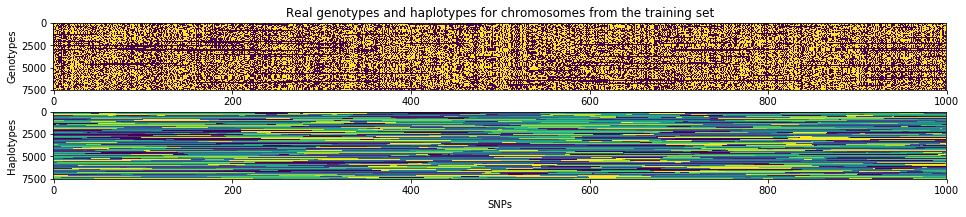

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 627s 84ms/step - loss: 2.7452 - acc: 0.0918 - val_loss: 2.6188 - val_acc: 0.1452

Epoch 00001: val_acc improved from -inf to 0.14520, saving model to Similarity1_model_weights-improvement-S_0.0-01-0.15.hdf5
Epoch 2/30
7500/7500 [==============================] - 654s 87ms/step - loss: 2.4466 - acc: 0.1690 - val_loss: 2.1392 - val_acc: 0.2343

Epoch 00002: val_acc improved from 0.14520 to 0.23428, saving model to Similarity1_model_weights-improvement-S_0.0-02-0.23.hdf5
Epoch 3/30
7500/7500 [==============================] - 644s 86ms/step - loss: 2.0941 - acc: 0.2406 - val_loss: 1.9444 - val_acc: 0.2725

Epoch 00003: val_acc improved from 0.23428 to 0.27247, saving model to Similarity1_model_weights-improvement-S_0.0-03-0.27.hdf5
Epoch 4/30
7500/7500 [==============================] - 646s 86ms/step - loss: 1.8937 - acc: 0.2938 - val_loss: 1.7077 - val_acc: 0.3457

Epoch 00004: val_ac

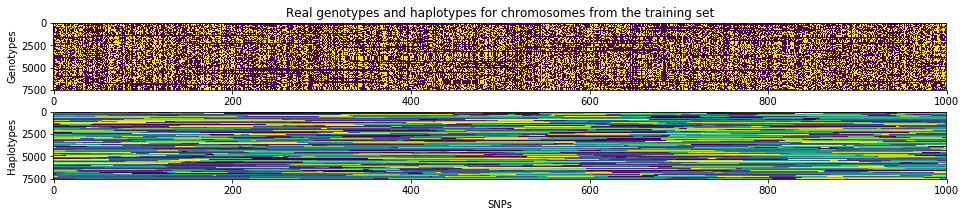

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 623s 83ms/step - loss: 2.7615 - acc: 0.0757 - val_loss: 2.7113 - val_acc: 0.1139

Epoch 00001: val_acc improved from -inf to 0.11389, saving model to Similarity1_model_weights-improvement-S_0.05-01-0.11.hdf5
Epoch 2/30
7500/7500 [==============================] - 580s 77ms/step - loss: 2.6354 - acc: 0.1247 - val_loss: 2.5417 - val_acc: 0.1292

Epoch 00002: val_acc improved from 0.11389 to 0.12916, saving model to Similarity1_model_weights-improvement-S_0.05-02-0.13.hdf5
Epoch 3/30
7500/7500 [==============================] - 580s 77ms/step - loss: 2.5629 - acc: 0.1339 - val_loss: 2.5274 - val_acc: 0.1385

Epoch 00003: val_acc improved from 0.12916 to 0.13849, saving model to Similarity1_model_weights-improvement-S_0.05-03-0.14.hdf5
Epoch 4/30
7500/7500 [==============================] - 1848s 246ms/step - loss: 2.5537 - acc: 0.1394 - val_loss: 2.5222 - val_acc: 0.1445

Epoch 00004: v

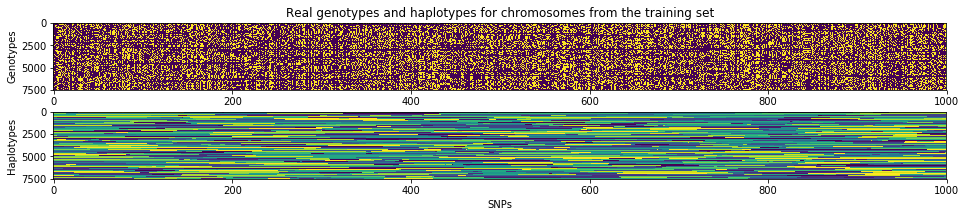

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 689s 92ms/step - loss: 2.7497 - acc: 0.0947 - val_loss: 2.6771 - val_acc: 0.1028

Epoch 00001: val_acc improved from -inf to 0.10280, saving model to Similarity1_model_weights-improvement-S_0.1-01-0.10.hdf5
Epoch 2/30
7500/7500 [==============================] - 665s 89ms/step - loss: 2.5971 - acc: 0.1256 - val_loss: 2.5617 - val_acc: 0.1122

Epoch 00002: val_acc improved from 0.10280 to 0.11224, saving model to Similarity1_model_weights-improvement-S_0.1-02-0.11.hdf5
Epoch 3/30
7500/7500 [==============================] - 706s 94ms/step - loss: 2.5612 - acc: 0.1295 - val_loss: 2.5554 - val_acc: 0.1109

Epoch 00003: val_acc did not improve from 0.11224
Epoch 4/30
7500/7500 [==============================] - 733s 98ms/step - loss: 2.5552 - acc: 0.1326 - val_loss: 2.5512 - val_acc: 0.1157

Epoch 00004: val_acc improved from 0.11224 to 0.11571, saving model to Similarity1_model_weights-

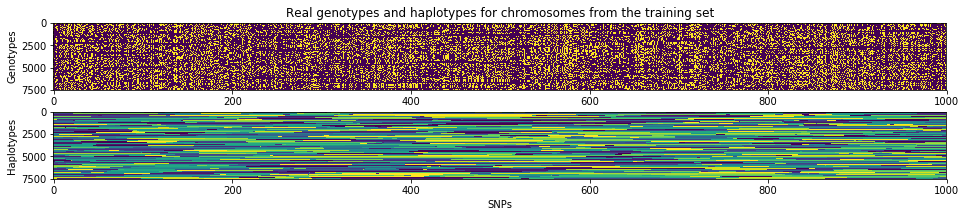

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 614s 82ms/step - loss: 2.7670 - acc: 0.0678 - val_loss: 2.7496 - val_acc: 0.0992

Epoch 00001: val_acc improved from -inf to 0.09923, saving model to Similarity1_model_weights-improvement-S_0.15-01-0.10.hdf5
Epoch 2/30
7500/7500 [==============================] - 637s 85ms/step - loss: 2.6700 - acc: 0.1159 - val_loss: 2.5737 - val_acc: 0.1283

Epoch 00002: val_acc improved from 0.09923 to 0.12827, saving model to Similarity1_model_weights-improvement-S_0.15-02-0.13.hdf5
Epoch 3/30
7500/7500 [==============================] - 635s 85ms/step - loss: 2.5761 - acc: 0.1257 - val_loss: 2.5576 - val_acc: 0.1425

Epoch 00003: val_acc improved from 0.12827 to 0.14253, saving model to Similarity1_model_weights-improvement-S_0.15-03-0.14.hdf5
Epoch 4/30
7500/7500 [==============================] - 641s 85ms/step - loss: 2.5664 - acc: 0.1292 - val_loss: 2.5543 - val_acc: 0.1476

Epoch 00004: val

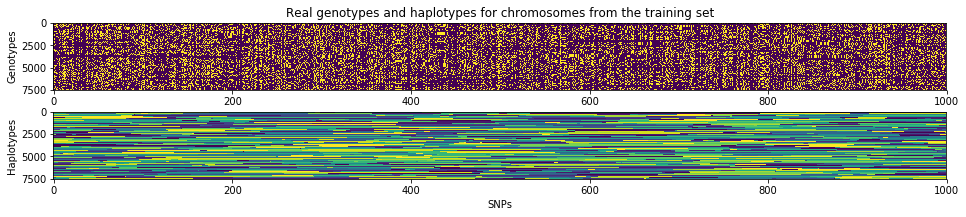

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 735s 98ms/step - loss: 2.7528 - acc: 0.0890 - val_loss: 2.7091 - val_acc: 0.1084

Epoch 00001: val_acc improved from -inf to 0.10844, saving model to Similarity1_model_weights-improvement-S_0.2-01-0.11.hdf5
Epoch 2/30
7500/7500 [==============================] - 673s 90ms/step - loss: 2.6058 - acc: 0.1374 - val_loss: 2.5736 - val_acc: 0.1249

Epoch 00002: val_acc improved from 0.10844 to 0.12486, saving model to Similarity1_model_weights-improvement-S_0.2-02-0.12.hdf5
Epoch 3/30
7500/7500 [==============================] - 662s 88ms/step - loss: 2.5387 - acc: 0.1468 - val_loss: 2.5519 - val_acc: 0.1332

Epoch 00003: val_acc improved from 0.12486 to 0.13315, saving model to Similarity1_model_weights-improvement-S_0.2-03-0.13.hdf5
Epoch 4/30
7500/7500 [==============================] - 651s 87ms/step - loss: 2.4894 - acc: 0.1655 - val_loss: 2.4427 - val_acc: 0.1596

Epoch 00004: val_ac

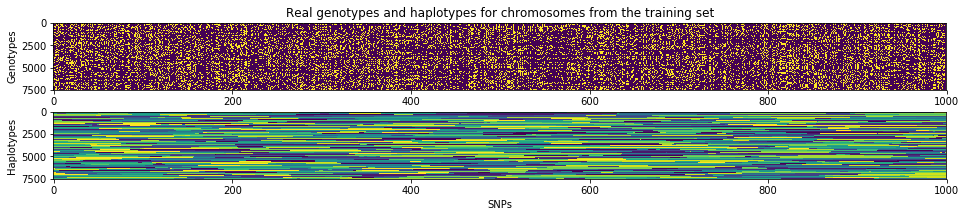

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 651s 87ms/step - loss: 2.7542 - acc: 0.0789 - val_loss: 2.7132 - val_acc: 0.1060

Epoch 00001: val_acc improved from -inf to 0.10604, saving model to Similarity1_model_weights-improvement-S_0.25-01-0.11.hdf5
Epoch 2/30
7500/7500 [==============================] - 649s 86ms/step - loss: 2.6510 - acc: 0.1255 - val_loss: 2.6055 - val_acc: 0.1124

Epoch 00002: val_acc improved from 0.10604 to 0.11239, saving model to Similarity1_model_weights-improvement-S_0.25-02-0.11.hdf5
Epoch 3/30
7500/7500 [==============================] - 658s 88ms/step - loss: 2.5795 - acc: 0.1352 - val_loss: 2.5855 - val_acc: 0.1213

Epoch 00003: val_acc improved from 0.11239 to 0.12128, saving model to Similarity1_model_weights-improvement-S_0.25-03-0.12.hdf5
Epoch 4/30
7500/7500 [==============================] - 650s 87ms/step - loss: 2.5598 - acc: 0.1418 - val_loss: 2.5123 - val_acc: 0.1437

Epoch 00004: val

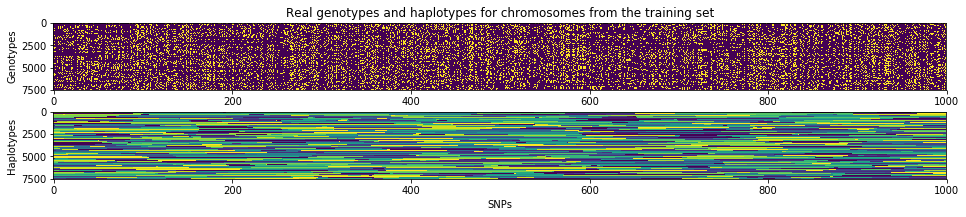

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 739s 99ms/step - loss: 2.7659 - acc: 0.0889 - val_loss: 2.7499 - val_acc: 0.1262

Epoch 00001: val_acc improved from -inf to 0.12624, saving model to Similarity1_model_weights-improvement-S_0.3-01-0.13.hdf5
Epoch 2/30
7500/7500 [==============================] - 717s 96ms/step - loss: 2.6681 - acc: 0.1308 - val_loss: 2.5887 - val_acc: 0.1295

Epoch 00002: val_acc improved from 0.12624 to 0.12950, saving model to Similarity1_model_weights-improvement-S_0.3-02-0.13.hdf5
Epoch 3/30
7500/7500 [==============================] - 707s 94ms/step - loss: 2.5484 - acc: 0.1521 - val_loss: 2.5452 - val_acc: 0.1554

Epoch 00003: val_acc improved from 0.12950 to 0.15539, saving model to Similarity1_model_weights-improvement-S_0.3-03-0.16.hdf5
Epoch 4/30
7500/7500 [==============================] - 703s 94ms/step - loss: 2.4489 - acc: 0.1896 - val_loss: 2.3581 - val_acc: 0.1936

Epoch 00004: val_ac

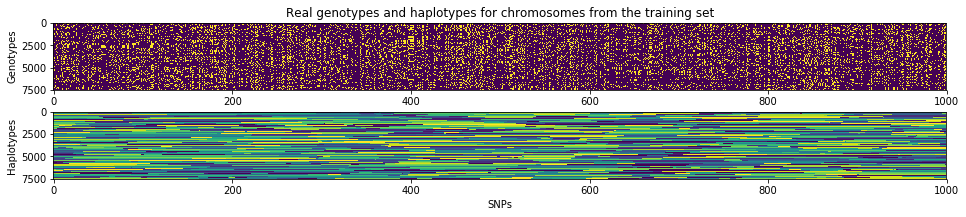

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 636s 85ms/step - loss: 2.7657 - acc: 0.0773 - val_loss: 2.7482 - val_acc: 0.1370

Epoch 00001: val_acc improved from -inf to 0.13696, saving model to Similarity1_model_weights-improvement-S_0.35-01-0.14.hdf5
Epoch 2/30
7500/7500 [==============================] - 635s 85ms/step - loss: 2.6765 - acc: 0.1229 - val_loss: 2.5735 - val_acc: 0.1334

Epoch 00002: val_acc did not improve from 0.13696
Epoch 3/30
7500/7500 [==============================] - 620s 83ms/step - loss: 2.5753 - acc: 0.1312 - val_loss: 2.5424 - val_acc: 0.1390

Epoch 00003: val_acc improved from 0.13696 to 0.13904, saving model to Similarity1_model_weights-improvement-S_0.35-03-0.14.hdf5
Epoch 4/30
7500/7500 [==============================] - 636s 85ms/step - loss: 2.5516 - acc: 0.1410 - val_loss: 2.4691 - val_acc: 0.1794

Epoch 00004: val_acc improved from 0.13904 to 0.17941, saving model to Similarity1_model_weight

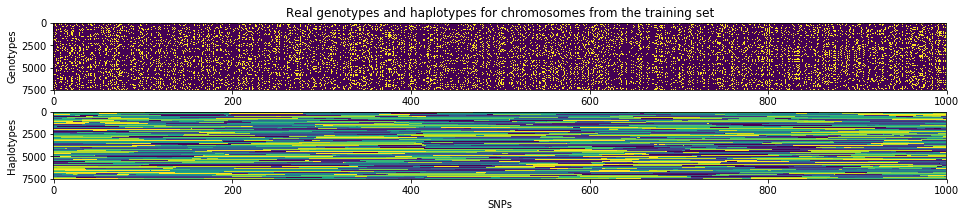

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 603s 80ms/step - loss: 2.7642 - acc: 0.0677 - val_loss: 2.7369 - val_acc: 0.0574

Epoch 00001: val_acc improved from -inf to 0.05744, saving model to Similarity1_model_weights-improvement-S_0.4-01-0.06.hdf5
Epoch 2/30
7500/7500 [==============================] - 629s 84ms/step - loss: 2.6777 - acc: 0.1128 - val_loss: 2.5658 - val_acc: 0.1374

Epoch 00002: val_acc improved from 0.05744 to 0.13743, saving model to Similarity1_model_weights-improvement-S_0.4-02-0.14.hdf5
Epoch 3/30
7500/7500 [==============================] - 630s 84ms/step - loss: 2.5954 - acc: 0.1242 - val_loss: 2.5442 - val_acc: 0.1344

Epoch 00003: val_acc did not improve from 0.13743
Epoch 4/30
7500/7500 [==============================] - 626s 83ms/step - loss: 2.5854 - acc: 0.1289 - val_loss: 2.5360 - val_acc: 0.1439

Epoch 00004: val_acc improved from 0.13743 to 0.14393, saving model to Similarity1_model_weights-

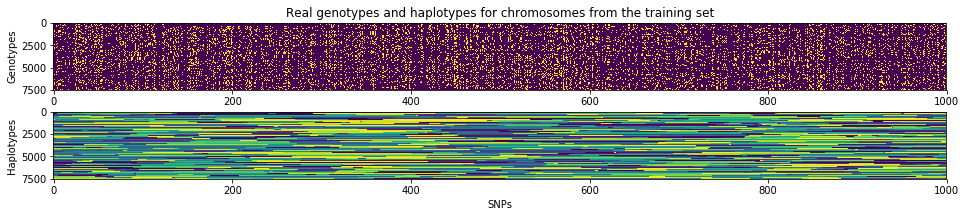

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 700s 93ms/step - loss: 2.7568 - acc: 0.1092 - val_loss: 2.7207 - val_acc: 0.1247

Epoch 00001: val_acc improved from -inf to 0.12470, saving model to Similarity1_model_weights-improvement-S_0.45-01-0.12.hdf5
Epoch 2/30
7500/7500 [==============================] - 702s 94ms/step - loss: 2.6128 - acc: 0.1407 - val_loss: 2.5862 - val_acc: 0.1311

Epoch 00002: val_acc improved from 0.12470 to 0.13113, saving model to Similarity1_model_weights-improvement-S_0.45-02-0.13.hdf5
Epoch 3/30
7500/7500 [==============================] - 695s 93ms/step - loss: 2.5394 - acc: 0.1489 - val_loss: 2.5229 - val_acc: 0.1508

Epoch 00003: val_acc improved from 0.13113 to 0.15080, saving model to Similarity1_model_weights-improvement-S_0.45-03-0.15.hdf5
Epoch 4/30
7500/7500 [==============================] - 701s 93ms/step - loss: 2.4078 - acc: 0.1791 - val_loss: 2.3037 - val_acc: 0.1774

Epoch 00004: val

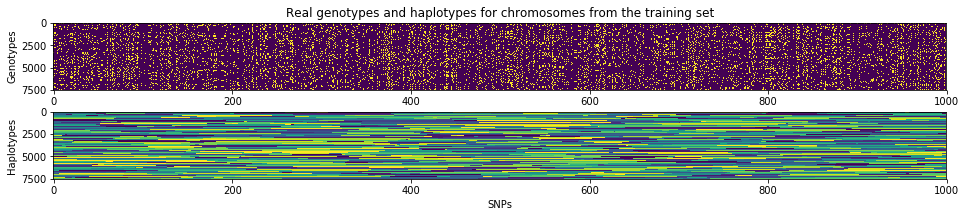

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 652s 87ms/step - loss: 2.7655 - acc: 0.0753 - val_loss: 2.7617 - val_acc: 0.0826

Epoch 00001: val_acc improved from -inf to 0.08265, saving model to Similarity1_model_weights-improvement-S_0.5-01-0.08.hdf5
Epoch 2/30
7500/7500 [==============================] - 666s 89ms/step - loss: 2.7417 - acc: 0.0846 - val_loss: 2.6872 - val_acc: 0.1373

Epoch 00002: val_acc improved from 0.08265 to 0.13733, saving model to Similarity1_model_weights-improvement-S_0.5-02-0.14.hdf5
Epoch 3/30
7500/7500 [==============================] - 672s 90ms/step - loss: 2.5464 - acc: 0.1377 - val_loss: 2.3651 - val_acc: 0.1579

Epoch 00003: val_acc improved from 0.13733 to 0.15788, saving model to Similarity1_model_weights-improvement-S_0.5-03-0.16.hdf5
Epoch 4/30
7500/7500 [==============================] - 678s 90ms/step - loss: 2.2875 - acc: 0.1851 - val_loss: 2.1454 - val_acc: 0.1867

Epoch 00004: val_ac

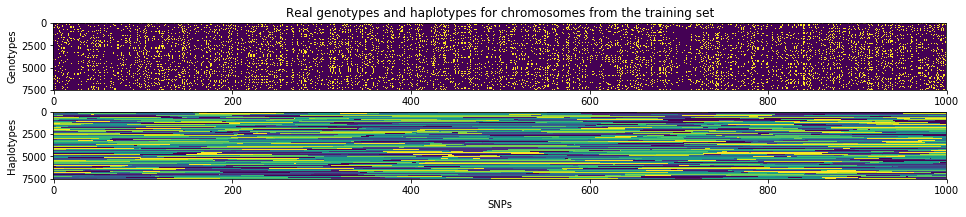

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 630s 84ms/step - loss: 2.7650 - acc: 0.0847 - val_loss: 2.7479 - val_acc: 0.1185

Epoch 00001: val_acc improved from -inf to 0.11848, saving model to Similarity1_model_weights-improvement-S_0.55-01-0.12.hdf5
Epoch 2/30
7500/7500 [==============================] - 630s 84ms/step - loss: 2.6890 - acc: 0.1293 - val_loss: 2.6170 - val_acc: 0.1249

Epoch 00002: val_acc improved from 0.11848 to 0.12485, saving model to Similarity1_model_weights-improvement-S_0.55-02-0.12.hdf5
Epoch 3/30
7500/7500 [==============================] - 636s 85ms/step - loss: 2.5755 - acc: 0.1373 - val_loss: 2.5740 - val_acc: 0.1308

Epoch 00003: val_acc improved from 0.12485 to 0.13083, saving model to Similarity1_model_weights-improvement-S_0.55-03-0.13.hdf5
Epoch 4/30
7500/7500 [==============================] - 649s 86ms/step - loss: 2.5566 - acc: 0.1438 - val_loss: 2.5741 - val_acc: 0.1356

Epoch 00004: val

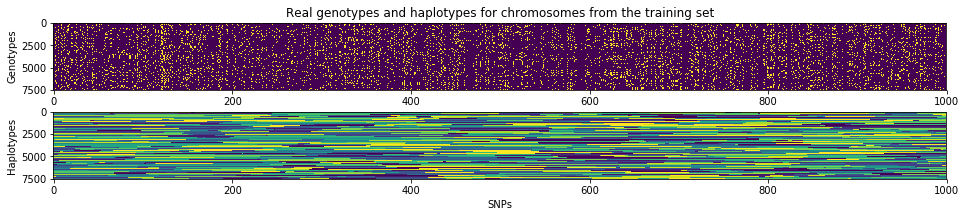

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 595s 79ms/step - loss: 2.7686 - acc: 0.0753 - val_loss: 2.7809 - val_acc: 0.0503

Epoch 00001: val_acc improved from -inf to 0.05033, saving model to Similarity1_model_weights-improvement-S_0.6-01-0.05.hdf5
Epoch 2/30
7500/7500 [==============================] - 632s 84ms/step - loss: 2.7573 - acc: 0.0799 - val_loss: 2.7451 - val_acc: 0.1034

Epoch 00002: val_acc improved from 0.05033 to 0.10336, saving model to Similarity1_model_weights-improvement-S_0.6-02-0.10.hdf5
Epoch 3/30
7500/7500 [==============================] - 655s 87ms/step - loss: 2.6292 - acc: 0.1398 - val_loss: 2.4835 - val_acc: 0.1437

Epoch 00003: val_acc improved from 0.10336 to 0.14367, saving model to Similarity1_model_weights-improvement-S_0.6-03-0.14.hdf5
Epoch 4/30
7500/7500 [==============================] - 669s 89ms/step - loss: 2.3791 - acc: 0.1720 - val_loss: 2.3126 - val_acc: 0.1550

Epoch 00004: val_ac

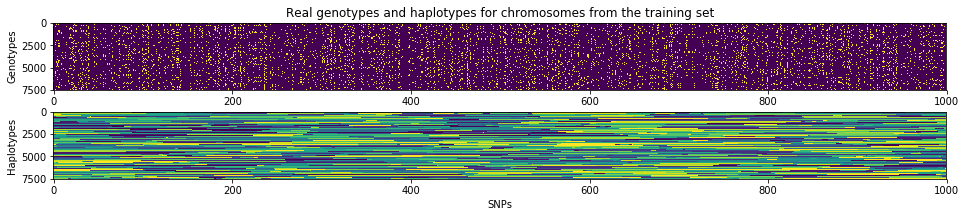

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 637s 85ms/step - loss: 2.7650 - acc: 0.0733 - val_loss: 2.7852 - val_acc: 0.0556

Epoch 00001: val_acc improved from -inf to 0.05558, saving model to Similarity1_model_weights-improvement-S_0.65-01-0.06.hdf5
Epoch 2/30
7500/7500 [==============================] - 667s 89ms/step - loss: 2.7534 - acc: 0.0771 - val_loss: 2.7557 - val_acc: 0.0581

Epoch 00002: val_acc improved from 0.05558 to 0.05813, saving model to Similarity1_model_weights-improvement-S_0.65-02-0.06.hdf5
Epoch 3/30
7500/7500 [==============================] - 639s 85ms/step - loss: 2.6455 - acc: 0.1080 - val_loss: 2.4562 - val_acc: 0.1219

Epoch 00003: val_acc improved from 0.05813 to 0.12187, saving model to Similarity1_model_weights-improvement-S_0.65-03-0.12.hdf5
Epoch 4/30
7500/7500 [==============================] - 635s 85ms/step - loss: 2.3878 - acc: 0.1471 - val_loss: 2.2853 - val_acc: 0.1452

Epoch 00004: val

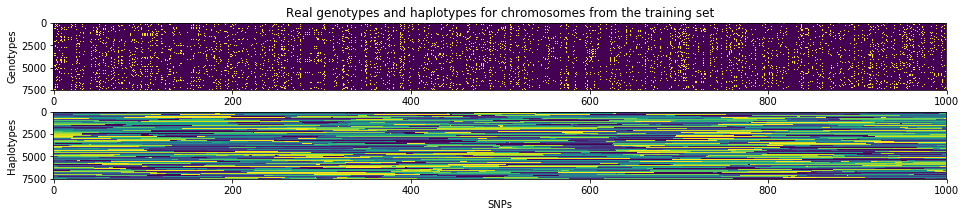

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 673s 90ms/step - loss: 2.7644 - acc: 0.0786 - val_loss: 2.7539 - val_acc: 0.0721

Epoch 00001: val_acc improved from -inf to 0.07207, saving model to Similarity1_model_weights-improvement-S_0.7-01-0.07.hdf5
Epoch 2/30
7500/7500 [==============================] - 676s 90ms/step - loss: 2.7140 - acc: 0.1144 - val_loss: 2.6435 - val_acc: 0.1271

Epoch 00002: val_acc improved from 0.07207 to 0.12711, saving model to Similarity1_model_weights-improvement-S_0.7-02-0.13.hdf5
Epoch 3/30
7500/7500 [==============================] - 731s 98ms/step - loss: 2.6198 - acc: 0.1359 - val_loss: 2.5873 - val_acc: 0.1335

Epoch 00003: val_acc improved from 0.12711 to 0.13354, saving model to Similarity1_model_weights-improvement-S_0.7-03-0.13.hdf5
Epoch 4/30
7500/7500 [==============================] - 703s 94ms/step - loss: 2.5040 - acc: 0.1621 - val_loss: 2.3542 - val_acc: 0.1615

Epoch 00004: val_ac

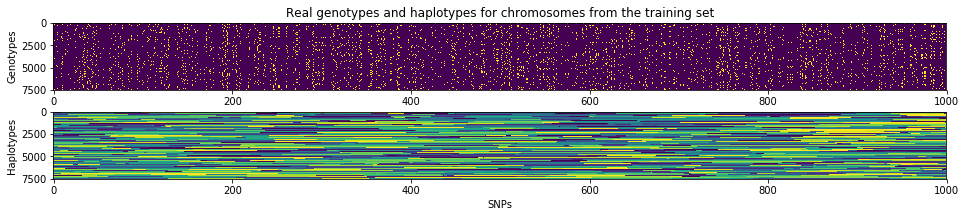

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 626s 83ms/step - loss: 2.7686 - acc: 0.0699 - val_loss: 2.7563 - val_acc: 0.0930

Epoch 00001: val_acc improved from -inf to 0.09297, saving model to Similarity1_model_weights-improvement-S_0.75-01-0.09.hdf5
Epoch 2/30
7500/7500 [==============================] - 641s 85ms/step - loss: 2.7199 - acc: 0.1069 - val_loss: 2.5945 - val_acc: 0.1224

Epoch 00002: val_acc improved from 0.09297 to 0.12240, saving model to Similarity1_model_weights-improvement-S_0.75-02-0.12.hdf5
Epoch 3/30
7500/7500 [==============================] - 615s 82ms/step - loss: 2.5086 - acc: 0.1275 - val_loss: 2.3885 - val_acc: 0.1543

Epoch 00003: val_acc improved from 0.12240 to 0.15431, saving model to Similarity1_model_weights-improvement-S_0.75-03-0.15.hdf5
Epoch 4/30
7500/7500 [==============================] - 638s 85ms/step - loss: 2.3197 - acc: 0.1767 - val_loss: 2.1424 - val_acc: 0.2197

Epoch 00004: val

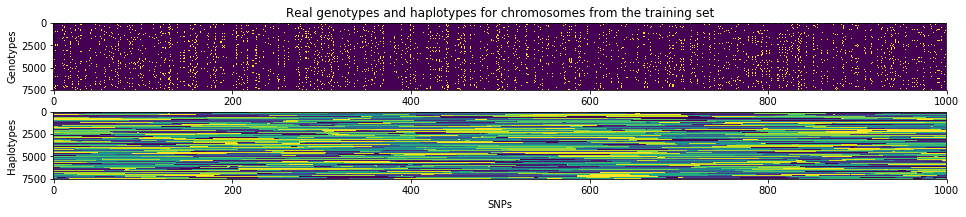

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 628s 84ms/step - loss: 2.7669 - acc: 0.0729 - val_loss: 2.7650 - val_acc: 0.0644

Epoch 00001: val_acc improved from -inf to 0.06442, saving model to Similarity1_model_weights-improvement-S_0.8-01-0.06.hdf5
Epoch 2/30
7500/7500 [==============================] - 650s 87ms/step - loss: 2.7230 - acc: 0.0953 - val_loss: 2.6042 - val_acc: 0.0994

Epoch 00002: val_acc improved from 0.06442 to 0.09940, saving model to Similarity1_model_weights-improvement-S_0.8-02-0.10.hdf5
Epoch 3/30
7500/7500 [==============================] - 642s 86ms/step - loss: 2.4807 - acc: 0.1181 - val_loss: 2.3998 - val_acc: 0.1244

Epoch 00003: val_acc improved from 0.09940 to 0.12442, saving model to Similarity1_model_weights-improvement-S_0.8-03-0.12.hdf5
Epoch 4/30
7500/7500 [==============================] - 636s 85ms/step - loss: 2.3703 - acc: 0.1387 - val_loss: 2.3377 - val_acc: 0.1506

Epoch 00004: val_ac

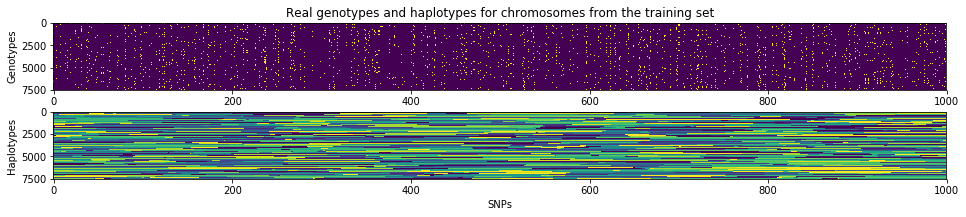

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 620s 83ms/step - loss: 2.7660 - acc: 0.0712 - val_loss: 2.7600 - val_acc: 0.0778

Epoch 00001: val_acc improved from -inf to 0.07783, saving model to Similarity1_model_weights-improvement-S_0.85-01-0.08.hdf5
Epoch 2/30
7500/7500 [==============================] - 636s 85ms/step - loss: 2.6985 - acc: 0.1001 - val_loss: 2.5275 - val_acc: 0.1327

Epoch 00002: val_acc improved from 0.07783 to 0.13270, saving model to Similarity1_model_weights-improvement-S_0.85-02-0.13.hdf5
Epoch 3/30
7500/7500 [==============================] - 626s 83ms/step - loss: 2.4840 - acc: 0.1258 - val_loss: 2.4324 - val_acc: 0.1111

Epoch 00003: val_acc did not improve from 0.13270
Epoch 4/30
7500/7500 [==============================] - 648s 86ms/step - loss: 2.4277 - acc: 0.1388 - val_loss: 2.3979 - val_acc: 0.1385

Epoch 00004: val_acc improved from 0.13270 to 0.13851, saving model to Similarity1_model_weight

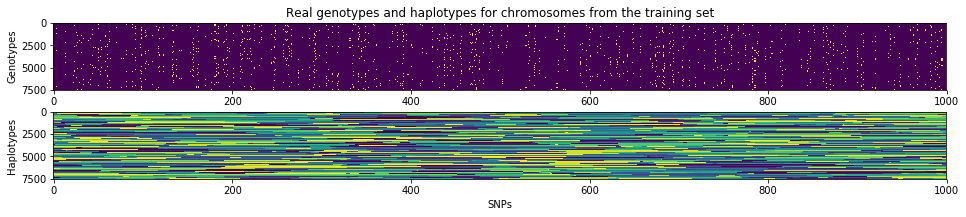

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 634s 85ms/step - loss: 2.7696 - acc: 0.0761 - val_loss: 2.7758 - val_acc: 0.0840

Epoch 00001: val_acc improved from -inf to 0.08399, saving model to Similarity1_model_weights-improvement-S_0.9-01-0.08.hdf5
Epoch 2/30
7500/7500 [==============================] - 654s 87ms/step - loss: 2.7582 - acc: 0.0977 - val_loss: 2.7430 - val_acc: 0.0827

Epoch 00002: val_acc did not improve from 0.08399
Epoch 3/30
7500/7500 [==============================] - 646s 86ms/step - loss: 2.6780 - acc: 0.1018 - val_loss: 2.6168 - val_acc: 0.0877

Epoch 00003: val_acc improved from 0.08399 to 0.08770, saving model to Similarity1_model_weights-improvement-S_0.9-03-0.09.hdf5
Epoch 4/30
7500/7500 [==============================] - 647s 86ms/step - loss: 2.5780 - acc: 0.1077 - val_loss: 2.5595 - val_acc: 0.0972

Epoch 00004: val_acc improved from 0.08770 to 0.09717, saving model to Similarity1_model_weights-

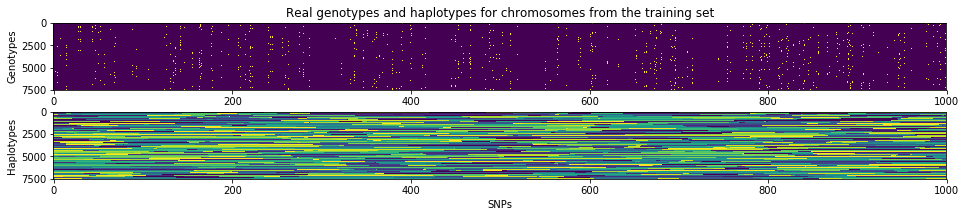

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 687s 92ms/step - loss: 2.7696 - acc: 0.0693 - val_loss: 2.7725 - val_acc: 0.0753

Epoch 00001: val_acc improved from -inf to 0.07531, saving model to Similarity1_model_weights-improvement-S_0.95-01-0.08.hdf5
Epoch 2/30
7500/7500 [==============================] - 683s 91ms/step - loss: 2.7661 - acc: 0.0721 - val_loss: 2.7677 - val_acc: 0.0721

Epoch 00002: val_acc did not improve from 0.07531
Epoch 3/30
7500/7500 [==============================] - 653s 87ms/step - loss: 2.7420 - acc: 0.0865 - val_loss: 2.6930 - val_acc: 0.0848

Epoch 00003: val_acc improved from 0.07531 to 0.08475, saving model to Similarity1_model_weights-improvement-S_0.95-03-0.08.hdf5
Epoch 4/30
7500/7500 [==============================] - 722s 96ms/step - loss: 2.6265 - acc: 0.1043 - val_loss: 2.5512 - val_acc: 0.1288

Epoch 00004: val_acc improved from 0.08475 to 0.12882, saving model to Similarity1_model_weight

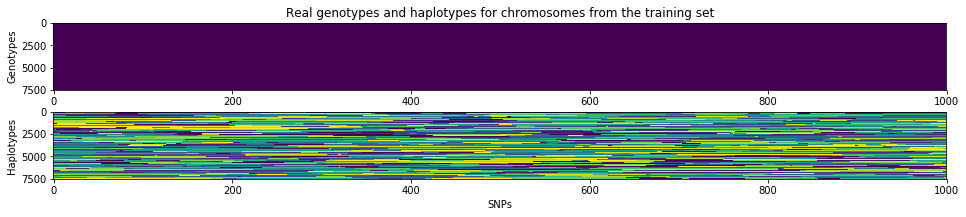

Train on 7500 samples, validate on 2500 samples
Epoch 1/30
7500/7500 [==============================] - 635s 85ms/step - loss: 2.7702 - acc: 0.0761 - val_loss: 2.7757 - val_acc: 0.0605

Epoch 00001: val_acc improved from -inf to 0.06053, saving model to Similarity1_model_weights-improvement-S_1.0-01-0.06.hdf5
Epoch 2/30
7500/7500 [==============================] - 663s 88ms/step - loss: 2.7689 - acc: 0.0761 - val_loss: 2.7760 - val_acc: 0.0605

Epoch 00002: val_acc did not improve from 0.06053
Epoch 3/30
7500/7500 [==============================] - 651s 87ms/step - loss: 2.7689 - acc: 0.0761 - val_loss: 2.7766 - val_acc: 0.0605

Epoch 00003: val_acc did not improve from 0.06053
Epoch 4/30
7500/7500 [==============================] - 659s 88ms/step - loss: 2.7688 - acc: 0.0761 - val_loss: 2.7765 - val_acc: 0.0605

Epoch 00004: val_acc did not improve from 0.06053
Epoch 5/30
7500/7500 [==============================] - 640s 85ms/step - loss: 2.7688 - acc: 0.0761 - val_loss: 2.7765 - val_

In [53]:
epochs = 30
history_1 = []

for k in range(L_S+1) :
    S = S_range[k]
    d_geno = d_genotypes[k]
    F_geno = F_genotypes[k]
    d_haplo = d_haplotypes[k]
    Xtrain, Ytrain, Xtest, Ytest = prepare_data (d_geno, d_haplo, F_geno, linkage, n)
    history = run_model (model_1, S, Xtrain, Ytrain, Xtest, Ytest, epochs)
    history_1.append(history)
    with open('Similarity1_model_history_S{}.pkl'.format(round(S,2)), 'wb') as handler:
        pickle.dump(history, handler)

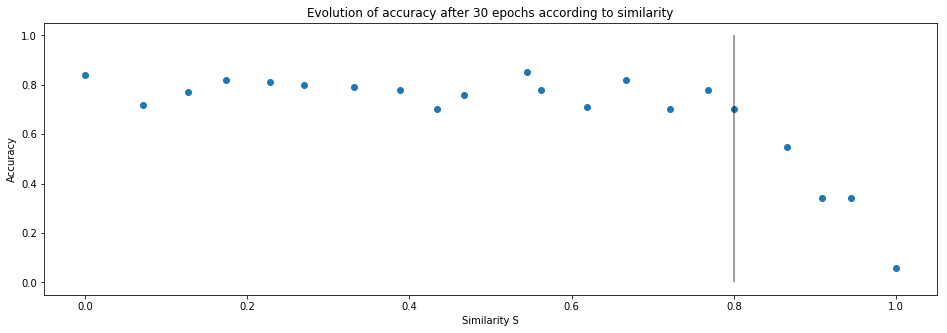

In [17]:
im, ax = plt.subplots(1,1, figsize = (16,5))
ax.vlines(0.8,0,1,alpha=0.5)
ax.scatter(S_range_computed,[0.84,0.72,0.77,0.82,0.81,0.80,0.79,0.78,0.70,0.76,0.85,0.78,0.71,0.82,0.70,0.78,0.70,0.55,0.34,0.34,0.06])
ax.set(xlabel = "Similarity S", ylabel = "Accuracy", title = "Evolution of accuracy after 30 epochs according to similarity")
plt.show()

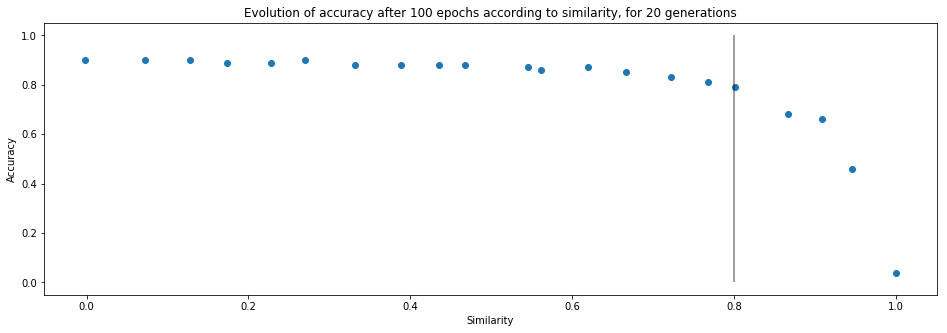

In [14]:
im, ax = plt.subplots(1,1, figsize = (16,5))
ax.vlines(0.8,0,1,alpha=0.5)
ax.scatter(S_range_computed,[0.90,0.90,0.90,0.89,0.89,0.90,0.88,0.88,0.88,0.88,0.87,0.86,0.87,0.85,0.83,0.81,0.79,0.68,0.66,0.46,0.04])
ax.set(xlabel = "Similarity", ylabel = "Accuracy", title = "Evolution of accuracy after 100 epochs according to similarity, for 20 generations")
plt.show()

In [2]:
with open("Similarity2_model_history_S0.05.pkl","rb") as handler:
    H = pickle.load(handler)

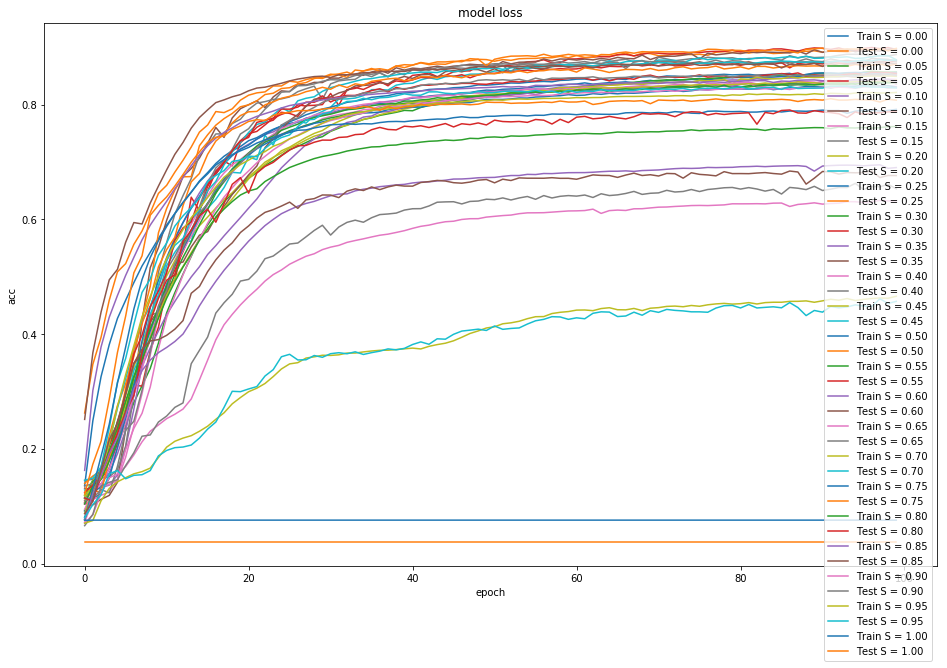

In [12]:
im, ax = plt.subplots(1,1, figsize = (16,10))
for S in S_range :
    with open("Similarity2_model_history_S{:.2f}.pkl".format(S),"rb") as handler:
        history = pickle.load(handler)
    ax.plot(history.history['acc'], label = "Train S = {:.2f}".format(S))
    ax.plot(history.history['val_acc'], label = "Test S = {:.2f}".format(S))
ax.set(title = 'model loss', ylabel = 'acc', xlabel = 'epoch')
ax.legend()
plt.show()

# Accuracy = f(similarity's mean + variance)

Now, both the mean and the variance of the 2 vs 2 similarities between founders are changed simultaneously.

## Simulate founders and recombination : 1000 SNPs

In [15]:
import numpy as np
from numpy.random import choice
import random as rd
import pandas as pd
import matplotlib.pyplot as plt
import copy 
import pickle
from pprint import pprint
import copy
%matplotlib inline

In [16]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [17]:
def recombine_linkage (parent_A,parent_B,linkage) :
    '''Recombines 2 parents' haplotypes at a random position chosen according to linkage'''
    r = choice(range(1,len(parent_A)),p=linkage)    # position of the recombination
    parent = rd.randint(0,1)
    child = np.copy([parent_A,parent_B][parent])
    child[r:] = [parent_A,parent_B][1-parent][r:]
    return child

def sample_parents (A) :
    '''Takes 2 parents among the individuals in a generation'''
    parent_A = rd.choice(A)
    parent_B = rd.choice(A)
    while (parent_B == parent_A).all() :
        parent_B = rd.choice(A)
    return parent_A,parent_B

def shuffle (A,G,N,p,linkage) :
    '''Recombines founders' haplotypes (p SNPs) for G generations with N individuals at each step.'''
    B=np.zeros((N,p),dtype=int)
    for k in range (N):
            (parent_A,parent_B)=sample_parents(A)                # First generation
            B[k] = recombine_linkage(parent_A,parent_B,linkage)
    A = np.copy(B)
    for g in range(1,G):
        for k in range (N):
            (parent_A,parent_B)=sample_parents(A)
            B[k] = recombine_linkage(parent_A,parent_B,linkage)
        np.copyto(A,B)
    return A

def reverse_SNPs (d_haplo,F_geno) :
    '''Converts an array of SNPs from haplotype to genotype.'''
    g = np.copy(d_haplo)
    for individual in g:
        for k in range (p):
            assert type(individual[k]-1)==np.int64, individual[k]
            individual[k]=F_geno[individual[k]-1][k]
    return g

In [391]:
n = 16    # number of founders
p = 1000  # nb of SNPs
G = 20    # nb of generations
N = 100   # nb of recombining individuals in a generation after sampling
I = 100   # nb of itérations

L_S = 20    # nb of intervals between similarity samplings for simulations
S_range = np.linspace(0,1,L_S+1)   # Similarity between founders

L_V = 10    # nb of intervals between variance samplings for simulations
V_range = np.linspace(0,0.5,L_V+1)   # standard deviation of the cross-similarity between founders

linkage = np.array([1/(p-1) for k in range(p)])   # uniform probability of recombination

In [124]:
def normalized_cross_similarity (array,n,p) :
    A = np.dot(array,array.T)+np.dot(1-array,1-array.T)
    B = A[np.triu_indices(n, k=1)]/p     # Extract the values that are above the diagonal
    return max(0,np.round(np.mean(B),5)*2-1)    # Normalize between 0 and 1

In [21]:
def similarity_standard_deviation(array,n,p):
    A = np.dot(array,array.T)+np.dot(1-array,1-array.T)
    B = A[np.triu_indices(n, k=1)]/p     # Extract the values that are above the diagonal
    return np.round(np.sqrt(np.var(B)),3)

In [158]:
def simulate_founders_similarity (p,n,S) :
    return np.random.choice([0,1],size=(n,p),p=[0.5+np.sqrt(S)/2,0.5-np.sqrt(S)/2])

f = simulate_founders_similarity (15,n,0.2)
display(f, normalized_cross_similarity(f,n,15), similarity_standard_deviation(f,n,15))

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0]])

0.22555999999999998

0.138

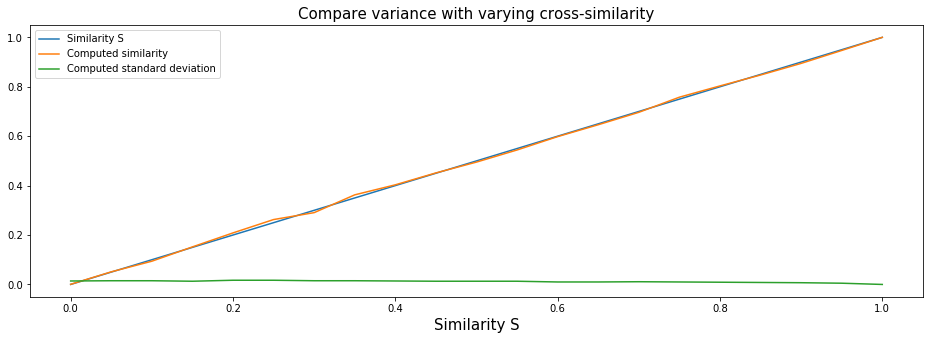

In [161]:
im, ax = plt.subplots(1,1,figsize = (16,5))
ax.plot(S_range, S_range, label = "Similarity S")
ax.plot(S_range,[normalized_cross_similarity(f_geno,n,p) for f_geno in [simulate_founders_similarity (p,n,S) for S in S_range]], label = "Computed similarity")
ax.plot(S_range,[similarity_standard_deviation(f_geno,n,p) for f_geno in [simulate_founders_similarity (p,n,S) for S in S_range]], label = "Computed standard deviation")
ax.set(title = "Compare variance with varying cross-similarity", xlabel ="Similarity S")
ax.legend()
plt.show()

In [309]:
def simulate_founders_variance (p,n,S,V) :
    F_geno = np.random.choice([0,1],size=(n,p),p=[min(1,0.5+np.sqrt(S/2)),max(0,0.5-np.sqrt(S/2))])
    v = (2*V)**1.5
    for i in range (1,n) :
            var = np.random.normal(v,v)
            for j in range (p) :
                if var < v and np.random.random()<var :
                    F_geno[i,j] = 0
                if var > v and np.random.random()<var :
                    F_geno[i,j] = 1
    return F_geno

f = simulate_founders_variance (15,n,0.5,0.2)
display(f, normalized_cross_similarity(f,n,15), similarity_standard_deviation(f,n,15))

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0],
       [1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0],
       [0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1]])

0.26888

0.267

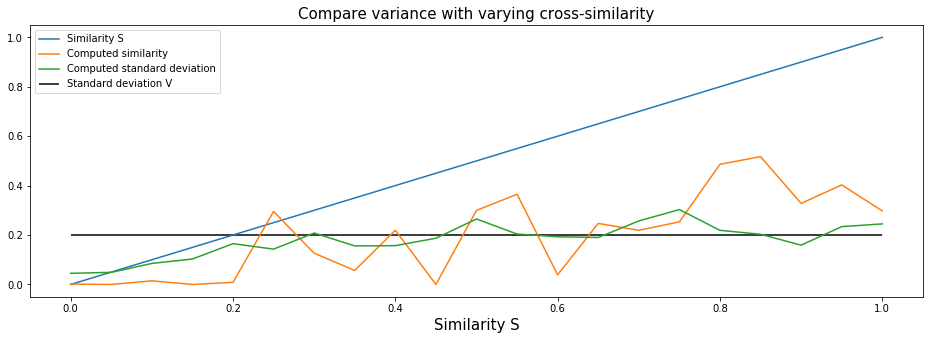

In [316]:
V = 0.2
im, ax = plt.subplots(1,1,figsize = (16,5))
ax.plot(S_range, S_range, label = "Similarity S")
ax.plot(S_range,[normalized_cross_similarity(f_geno,n,10000) for f_geno in [simulate_founders_variance (10000,n,S,V) for S in S_range]], label = "Computed similarity")
ax.hlines(V,0,1, label = "Standard deviation V")
ax.plot(S_range,[similarity_standard_deviation(f_geno,n,10000) for f_geno in [simulate_founders_variance (10000,n,S,V) for S in S_range]], label = "Computed standard deviation")
ax.set(title = "Compare variance with varying cross-similarity", xlabel ="Similarity S")
ax.legend()
plt.show()

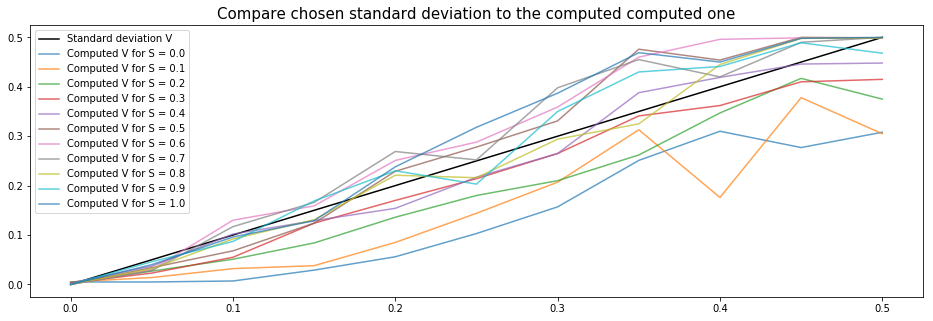

In [317]:
im, ax = plt.subplots(1,1,figsize = (16,5))
ax.plot(V_range,V_range, color = 'black', label = "Standard deviation V")
for S in S_range[::2] :
    ax.plot(V_range,[similarity_standard_deviation(f_geno,n,10000) for f_geno in [simulate_founders_variance (10000,n,S,V) for V in V_range]], label = "Computed V for S = {}".format(round(S,2)), alpha = 0.7)
ax.set(title = "Compare chosen standard deviation to the computed computed one")
ax.legend()
plt.show()

In [318]:
def simulate_founders_variance_constrained (p,n,S,V):
    array = simulate_founders_variance (p,n,S,V)
    loss = abs(S - normalized_cross_similarity (array,n,p)) + abs(V - similarity_standard_deviation(array,n,p))
    for k in range (1000):
        array_2 = simulate_founders_variance (p,n,S,V)
        loss_2 = abs(S - normalized_cross_similarity (array_2,n,p)) + abs(V - similarity_standard_deviation(array_2,n,p))
        if loss_2<loss :
            array = np.copy(array_2)
            loss = loss_2
    return array

simulate_founders_variance_constrained (p,n,0.3,0.2)

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0]])

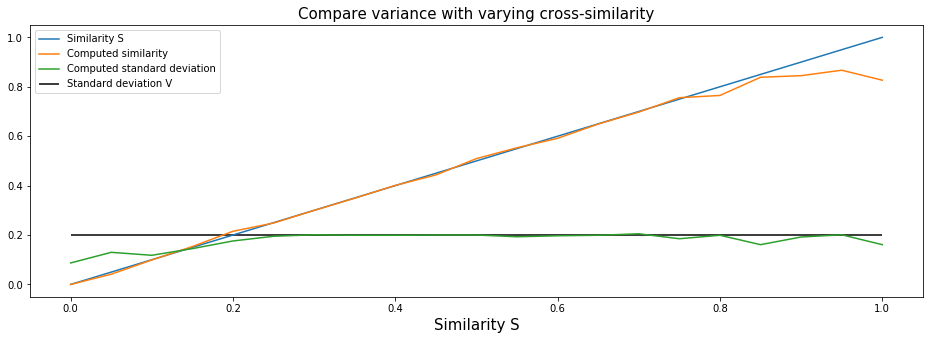

In [319]:
V = 0.2
im, ax = plt.subplots(1,1,figsize = (16,5))
ax.plot(S_range, S_range, label = "Similarity S")
ax.plot(S_range,[normalized_cross_similarity(f_geno,n,p) for f_geno in [simulate_founders_variance_constrained (p,n,S,V) for S in S_range]], label = "Computed similarity")
ax.hlines(V,0,1, label = "Standard deviation V")
ax.plot(S_range,[similarity_standard_deviation(f_geno,n,p) for f_geno in [simulate_founders_variance_constrained (p,n,S,V) for S in S_range]], label = "Computed standard deviation")
ax.set(title = "Compare variance with varying cross-similarity", xlabel ="Similarity S")
ax.legend()
plt.show()

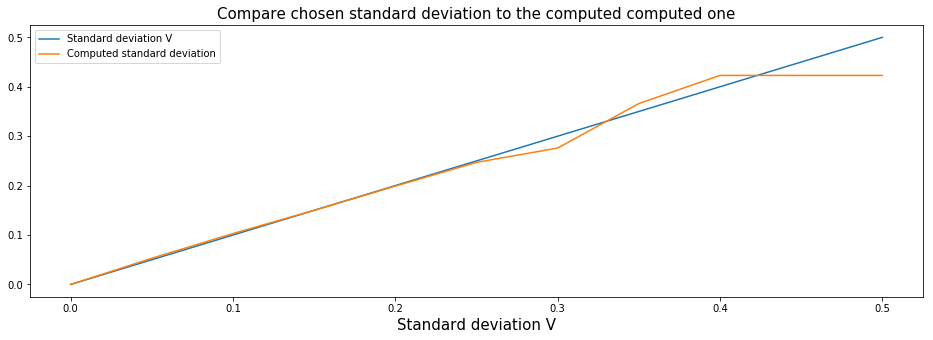

In [320]:
S = 0.5
im, ax = plt.subplots(1,1,figsize = (16,5))
ax.plot(V_range,V_range, label = "Standard deviation V")
ax.plot(V_range,[similarity_standard_deviation(f_geno,n,p) for f_geno in [simulate_founders_variance_constrained (p,n,S,V) for V in V_range]], label = "Computed standard deviation")
ax.set(title = "Compare chosen standard deviation to the computed computed one", xlabel="Standard deviation V")
ax.legend()
plt.show()

In [18]:
def iterate_and_save_variance (n,p,G,N,I,S,V,F_haplo,F_geno,linkage) :
    '''Simulates crossbreedings and saves the resulting genotypes (SNPs) + haplotypes in 2 binary files. '''
    haplo = np.zeros((n+N*I,p),dtype=int)
    haplo[:n] = F_haplo[:]
    geno = np.zeros((n+N*I,p),dtype=int)
    geno[:n] = F_geno[:]
    A = np.copy(F_haplo)
    for i in range (0,I):
        d_haplo = shuffle (A,G,N,p,linkage)
        haplo[n+i*N:n+(i+1)*N] = d_haplo                               # Add haplotypes of descentants (RILs)
        geno[n+i*N:n+(i+1)*N] = reverse_SNPs(d_haplo,F_geno)           # Add the conversion into genotypes
        if i//10==i/10 :
            print ("Iteration {0}/{1}".format(i,I))
    assert (F_haplo==np.array([[j for k in range(p)] for j in range(1,n+1)])).all(), F_haplo
    assert 0 not in d_haplo
    with open("Simulations_haplotypes_n{0}_p{1}_G{2}_N{3}_I{4}_S{5:.2f}_V{6:.2f}.pkl".format(n,p,G,N,I,S,V),"wb") as handler:
        pickle.dump(haplo.tolist(),handler)   # Lists take much less space
    with open("Simulations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}_S{5:.2f}_V{6:.2f}.pkl".format(n,p,G,N,I,S,V),"wb") as handler:
        pickle.dump(geno.tolist(),handler)

Résulting files :
   - Genotypes 1,0,1,0,1, ... ,1,0,1,0,0 =  
`[[[founder 1], ... , [founder 16]], [[[it 1 ind 1], ... ,[it 1 ind N]], ... ,[[it I ind 1], ... ,[it I ind N]]]`,
   - Haplotypes 3,3,3,12,12, ... ,1,1,1,1,1 =  
`[[[1,1,1,1,1,1], ... , [16,16,16,16,16,16]][[[1,1], ... ,[1,N]], ... ,[[I,1], ... ,[I,N]]]]`

In [322]:
S_range[::2], V_range

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]))

In [323]:
for S in S_range[::2]:
    print ("S : {0}/{1}".format(int(S*L_S),int(S_range[-1]*L_S)))
    for V in V_range :
        print ("V : {0}/{1}".format(int(V*L_V*2),int(V_range[-1]*L_V*2)))
        F_haplo = np.array([[j for i in range(p)] for j in range(1,n+1)])    # initial array (n founders and p SNPs)
        F_geno = simulate_founders_variance_constrained (p,n,S,V)
        iterate_and_save_variance (n,p,G,N,I,S,V,F_haplo,F_geno,linkage)

S : 0.0/20.0
V : 0.0/5.0
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
V : 0.5/5.0
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
V : 1.0/5.0
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
V : 1.5000000000000002/5.0
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
V : 2.0/5.0
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
V : 2.5/5.0
Iteration 0/100
Iteration 10/100
Iteration 20/100
Itera

Iteration 90/100
S : 8.0/20.0
V : 0.0/5.0
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
V : 0.5/5.0
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
V : 1.0/5.0
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
V : 1.5000000000000002/5.0
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
V : 2.0/5.0
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
V : 2.5/5.0
Iteration 0/100
Iteration 10/100
Itera

Iteration 70/100
Iteration 80/100
Iteration 90/100
S : 16.0/20.0
V : 0.0/5.0
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
V : 0.5/5.0
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
V : 1.0/5.0
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
V : 1.5000000000000002/5.0
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
V : 2.0/5.0
Iteration 0/100
Iteration 10/100
Iteration 20/100
Iteration 30/100
Iteration 40/100
Iteration 50/100
Iteration 60/100
Iteration 70/100
Iteration 80/100
Iteration 90/100
V : 2.5/5.0
Ite

In [325]:
F_haplotypes = []
d_haplotypes = []
F_genotypes = []
d_genotypes = []
for S in S_range[::2] :
    for V in V_range :
        with open("Simulations/Simulations_haplotypes_n{0}_p{1}_G{2}_N{3}_I{4}_S{5:.2f}_V{6:.2f}.pkl".format(n,p,G,N,I,S,V),"rb") as handler:
            haplo = pickle.load(handler)
            F_haplotypes.append(np.array(haplo[:n]))
            d_haplotypes.append(np.array(haplo[n:]))
        with open("Simulations/Simulations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}_S{5:.2f}_V{6:.2f}.pkl".format(n,p,G,N,I,S,V),"rb") as handler:
            haplo = pickle.load(handler)
            F_genotypes.append(np.array(haplo[:n]))
            d_genotypes.append(np.array(haplo[n:]))

In [335]:
print(len(F_haplotypes),F_haplotypes[0].shape,d_haplotypes[0].shape)

121 (16, 1000) (10000, 1000)


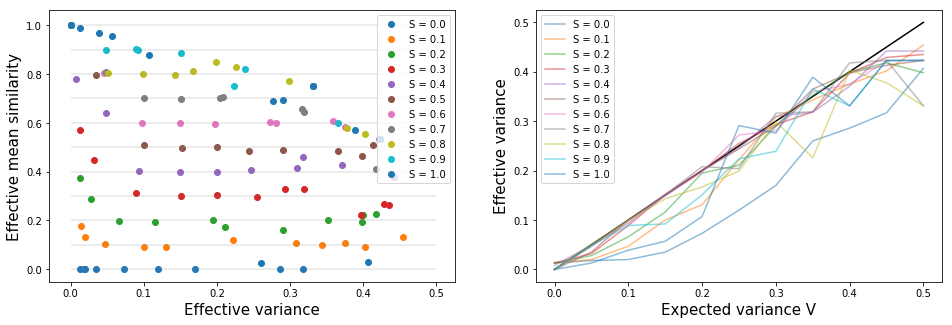

In [370]:
Sim = np.zeros((S_range[::2].shape[0],V_range.shape[0]))
Var = np.zeros((S_range[::2].shape[0],V_range.shape[0]))
k=0
for i in range(0,L_S+1,2) :
    S = S_range[i]
    for j in range(L_V+1) :
        V = V_range[j]
        Sim[i//2,j] = normalized_cross_similarity(F_genotypes[k],n,p)
        Var[i//2,j] = similarity_standard_deviation(F_genotypes[k],n,p)
        k+=1

im, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
ax2.plot([V_range[0],V_range[-1]],[V_range[0],V_range[-1]],color ='black')
for i in range(0,L_S+1,2) :
    S = S_range[i]
    ax1.hlines(S,V_range[0],V_range[-1], color = "grey", alpha = 0.2)
    ax1.scatter(Var[i//2], Sim[i//2], label = "S = {}".format(round(S,2)))
    ax2.plot(V_range, Var[i//2], label = "S = {}".format(round(S,2)), alpha = 0.5)
    ax1.set(xlabel = "Effective variance", ylabel = "Effective mean similarity", title = "")
    ax2.set(xlabel = "Expected variance V", ylabel = "Effective variance")
ax1.legend()
ax2.legend()
plt.show()

## Make predictions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM, TimeDistributed, Bidirectional
from keras.layers import Conv1D, Conv2D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils, plot_model
import pickle
%matplotlib inline

/Users/jeje/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
n = 16    # number of founders
p = 1000  # nb of SNPs
G = 20    # nb of generations
N = 100   # nb of recombining individuals in a generation after sampling
I = 100   # nb of itérations

L_S = 20    # nb of intervals between similarity samplings for simulations
S_range = np.linspace(0,1,L_S+1)   # Similarity between founders

L_V = 10    # nb of intervals between variance samplings for simulations
V_range = np.linspace(0,0.5,L_V+1)   # standard deviation of the cross-similarity between founders

linkage = np.array([1/(p-1) for k in range(p)])   # uniform probability of recombination

**Import simulations** : genotypes and haplotypes, F = founders, d = descendants

In [9]:
F_haplotypes = []
d_haplotypes = []
F_genotypes = []
d_genotypes = []
for S in S_range[::2] :
    for V in V_range :
        with open("Simulations/Simulations_haplotypes_n{0}_p{1}_G{2}_N{3}_I{4}_S{5:.2f}_V{6:.2f}.pkl".format(n,p,G,N,I,S,V),"rb") as handler:
            haplo = pickle.load(handler)
            F_haplotypes.append(np.array(haplo[:n]))
            d_haplotypes.append(np.array(haplo[n:]))
        with open("Simulations/Simulations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}_S{5:.2f}_V{6:.2f}.pkl".format(n,p,G,N,I,S,V),"rb") as handler:
            haplo = pickle.load(handler)
            F_genotypes.append(np.array(haplo[:n]))
            d_genotypes.append(np.array(haplo[n:]))

print(len(d_genotypes), F_haplotypes[0].shape, d_haplotypes[0].shape, F_genotypes[0].shape, d_genotypes[0].shape, linkage.shape)

121 (16, 1000) (10000, 1000) (16, 1000) (10000, 1000) (1000,)


In [10]:
def normalized_cross_similarity (array,n,p) :
    A = np.dot(array,array.T)+np.dot(1-array,1-array.T)
    B = A[np.triu_indices(n, k=1)]/p     # Extract the values that are above the diagonal
    return max(0,np.round(np.mean(B),5)*2-1)    # Normalize between 0 and 1

In [11]:
def similarity_standard_deviation(array,n,p):
    A = np.dot(array,array.T)+np.dot(1-array,1-array.T)
    B = A[np.triu_indices(n, k=1)]/p     # Extract the values that are above the diagonal
    return np.round(np.sqrt(np.var(B)),3)

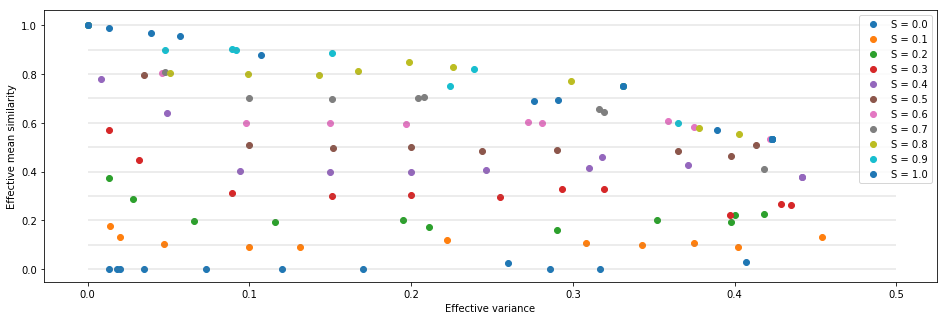

In [12]:
Sim = np.zeros((S_range[::2].shape[0],V_range.shape[0]))
Var = np.zeros((S_range[::2].shape[0],V_range.shape[0]))
k=0
for i in range(0,L_S+1,2) :
    S = S_range[i]
    for j in range(L_V+1) :
        V = V_range[j]
        Sim[i//2,j] = normalized_cross_similarity(F_genotypes[k],n,p)
        Var[i//2,j] = similarity_standard_deviation(F_genotypes[k],n,p)
        k+=1

im, ax = plt.subplots(1,1, figsize = (16,5))
for i in range(0,L_S+1,2) :
    S = S_range[i]
    ax.hlines(S,V_range[0],V_range[-1], color = "grey", alpha = 0.2)
    ax.scatter(Var[i//2], Sim[i//2], label = "S = {}".format(round(S,2)))
    ax.set(xlabel = "Effective variance", ylabel = "Effective mean similarity", title = "")
ax.legend()
plt.show()

**Input genotypes** : creating an "image" with the descendant x17 alterning with the 16 founders and the linkage.

In [13]:
def chromosome_alternate_inputs_5 (array, F_geno, linkage, n):
    A = np.zeros((array.shape[0],array.shape[1],3*n+1))
    for k in range(len(array)) :
        individual = array[k]
        a = individual[:, np.newaxis]
        for l in range(len(F_geno)) :
            a=np.concatenate([a,F_geno[l:l+1].T, linkage[:, np.newaxis], individual[:, np.newaxis]], axis = 1)
        A[k]=a
    return A

**Output haplotypes** in 2 SNPs-long segments.

In [14]:
def chromosome_segments_output (array):
    A = np.zeros((len(array),len(array[0])//2,16))
    for k in range(len(array)) :
        individual = array[k]
        A[k] = np.array([np_utils.to_categorical(segment[1]-1,16) for segment in np.reshape(individual[:len(individual)//2*2],(-1,2))])
    return A

In [15]:
def prepare_data (d_geno, d_haplo, F_geno, linkage, n) :
    xtrain = d_geno[:3*I*N//4]
    ytrain = d_haplo[:3*I*N//4]
    xtest = d_geno[3*I*N//4:]
    ytest = d_haplo[3*I*N//4:]
    
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,3))
    ax1.imshow(xtrain, aspect = 0.01)
    ax1.set(ylabel = "Genotypes", title = "Real genotypes and haplotypes for chromosomes from the training set")
    ax2.imshow(ytrain, aspect = 0.01)
    ax2.set(ylabel = "Haplotypes", xlabel = "SNPs")
    plt.show()
    
    Xtrain = chromosome_alternate_inputs_5(xtrain, F_geno, linkage, n)
    Ytrain = chromosome_segments_output(ytrain)
    Xtest = chromosome_alternate_inputs_5(xtest, F_geno, linkage, n)
    Ytest = chromosome_segments_output(ytest)
    
    return Xtrain, Ytrain, Xtest, Ytest

***Define LSTM***

In [16]:
K.clear_session()

model_3 = Sequential()
model_3.add(Conv1D(49, kernel_size=2,
                 activation='relu',
                 input_shape=(p,3*n+1), padding='same'))
model_3.add(Conv1D(30, kernel_size=2, activation='relu', padding='same'))
model_3.add(AveragePooling1D(pool_size=2,strides=2))
model_3.add(Dropout(0.25))
model_3.add(Conv1D(16, kernel_size=2, activation='relu', padding='same'))
model_3.add(Dropout(0.25))
model_3.add(TimeDistributed(Dense(16, activation='relu')))
model_3.add(Dropout(0.5))
model_3.add(TimeDistributed(Dense(16, activation='relu')))
model_3.add(Dropout(0.5))
model_3.add(Bidirectional(LSTM(8, return_sequences=True)))
model_3.add(TimeDistributed(Dense(n, activation='softmax')))
model_3.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
model_3.save_weights("Similarity3_model_initial_weights.hdf5")
#filepath="Similarity3_model_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]
print(model_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1000, 49)          4851      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1000, 30)          2970      
_________________________________________________________________
average_pooling1d_1 (Average (None, 500, 30)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 30)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 16)           976       
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 16)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 500, 16)           272       
__________

In [ ]:
plot_model(model_3, show_shapes=True, to_file='Similarity3_model.png')

***Train LSTM***

In [ ]:
def run_model (model, S, V, Xtrain, Ytrain, Xtest, Ytest, epochs):
    model_3.load_weights("Similarity3_model_initial_weights.hdf5")
    filepath="Similarity3_model_weights-improvement-"+"S_{0}-V_{1}".format(round(S,2),round(V,2))+"-{epoch:02d}-{val_acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history = model.fit(Xtrain, Ytrain,
                        epochs=epochs,
                        callbacks=callbacks_list,
                        verbose=1,
                        validation_data=(Xtest, Ytest))
    return history

In [ ]:
epochs = 1
history_3 = []

k=0
for S in S_range[::2] :
    for V in V_range :
        d_geno = d_genotypes[k]
        F_geno = F_genotypes[k]
        d_haplo = d_haplotypes[k]
        k+=1
        Xtrain, Ytrain, Xtest, Ytest = prepare_data (d_geno, d_haplo, F_geno, linkage, n)
        history = run_model (model_3, S, V, Xtrain, Ytrain, Xtest, Ytest, epochs)
        history_3.append(history)
        with open('Similarity3_model_history_S{}_V{}.pkl'.format(round(S,2),round(V,2)), 'wb') as handler:
            pickle.dump(history, handler)

## Plot results

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM, TimeDistributed, Bidirectional
from keras.layers import Conv1D, Conv2D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils, plot_model
import pickle
%matplotlib inline

/Users/jeje/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 22
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
n = 16    # number of founders
p = 1000  # nb of SNPs
G = 20    # nb of generations
N = 100   # nb of recombining individuals in a generation after sampling
I = 100   # nb of itérations

L_S = 20    # nb of intervals between similarity samplings for simulations
S_range = np.linspace(0,1,L_S+1)   # Similarity between founders

L_V = 10    # nb of intervals between variance samplings for simulations
V_range = np.linspace(0,0.5,L_V+1)   # standard deviation of the cross-similarity between founders

linkage = np.array([1/(p-1) for k in range(p)])   # uniform probability of recombination

**Import simulations** : genotypes and haplotypes, F = founders, d = descendants

In [4]:
F_haplotypes = []
d_haplotypes = []
F_genotypes = []
d_genotypes = []
for S in S_range[::2] :
    for V in V_range :
        with open("Simulations/Simulations_haplotypes_n{0}_p{1}_G{2}_N{3}_I{4}_S{5:.2f}_V{6:.2f}.pkl".format(n,p,G,N,I,S,V),"rb") as handler:
            haplo = pickle.load(handler)
            F_haplotypes.append(np.array(haplo[:n]))
            d_haplotypes.append(np.array(haplo[n:]))
        with open("Simulations/Simulations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}_S{5:.2f}_V{6:.2f}.pkl".format(n,p,G,N,I,S,V),"rb") as handler:
            haplo = pickle.load(handler)
            F_genotypes.append(np.array(haplo[:n]))
            d_genotypes.append(np.array(haplo[n:]))

print(len(d_genotypes), F_haplotypes[0].shape, d_haplotypes[0].shape, F_genotypes[0].shape, d_genotypes[0].shape, linkage.shape)

121 (16, 1000) (10000, 1000) (16, 1000) (10000, 1000) (1000,)


In [5]:
def normalized_cross_similarity (array,n,p) :
    A = np.dot(array,array.T)+np.dot(1-array,1-array.T)
    B = A[np.triu_indices(n, k=1)]/p     # Extract the values that are above the diagonal
    return max(0,np.round(np.mean(B),5)*2-1)    # Normalize between 0 and 1

In [6]:
def similarity_standard_deviation(array,n,p):
    A = np.dot(array,array.T)+np.dot(1-array,1-array.T)
    B = A[np.triu_indices(n, k=1)]/p     # Extract the values that are above the diagonal
    return np.round(np.sqrt(np.var(B)),3)

In [7]:
max_acc = np.array(
[[0.89,0.86,0.85,0.88,0.89,0.83,0.80,0.59,0.66,0.67,0.44]
,[0.88,0.87,0.85,0.90,0.89,0.81,0.63,0.53,0.45,0.44,0.34]
,[0.87,0.83,0.84,0.84,0.84,0.84,0.73,0.66,0.46,0.44,0.38]
,[0.86,0.85,0.88,0.83,0.88,0.88,0.86,0.82,0.44,0.33,0.32]
,[0.78,0.79,0.86,0.45,0.79,0.76,0.66,0.76,0.70,0.25,0.26]
,[0.05,0.74,0.73,0.52,0.49,0.39,0.26,0.23,0.27,0.25,0.16]
,[0.09,0.69,0.63,0.47,0.39,0.27,0.24,0.24,0.22,0.14,0.13]
,[0.06,0.62,0.48,0.39,0.25,0.22,0.21,0.17,0.25,0.13,0.18]
,[0.07,0.62,0.39,0.27,0.16,0.12,0.13,0.15,0.24,0.21,0.13]
,[0.06,0.41,0.19,0.20,0.13,0.22,0.15,0.19,0.16,0.14,0.15]
,[0.07,0.12,0.11,0.13,0.20,0.22,0.21,0.19,0.18,0.16,0.12]])

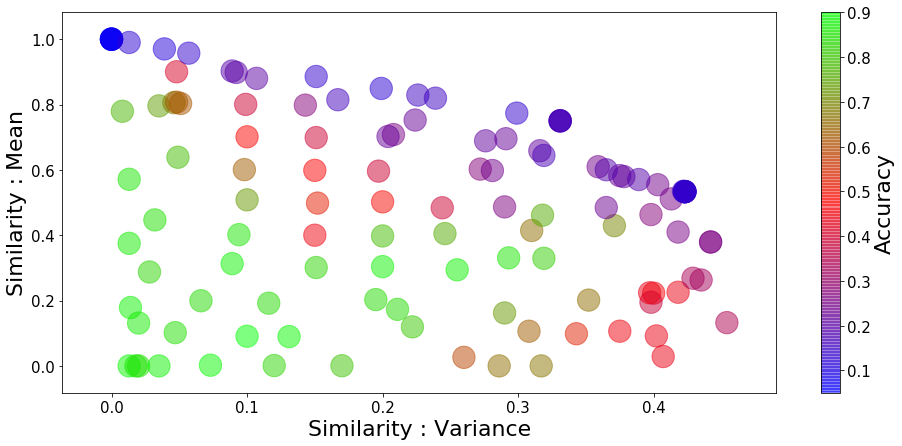

In [8]:
Sim = np.zeros((S_range[::2].shape[0],V_range.shape[0]))
Var = np.zeros((S_range[::2].shape[0],V_range.shape[0]))
k=0
for i in range(0,L_S+1,2) :
    S = S_range[i]
    for j in range(L_V+1) :
        V = V_range[j]
        Sim[i//2,j] = normalized_cross_similarity(F_genotypes[k],n,p)
        Var[i//2,j] = similarity_standard_deviation(F_genotypes[k],n,p)
        k+=1

im, ax = plt.subplots(1,1, figsize = (16,7))
s = ax.scatter(Var, Sim, s = 500, c = max_acc, alpha = 0.5, cmap = "brg")
#ax.scatter([0.163,0.015],[0.047,0.001], marker = "v", s = 500, c = [0.43,0.87], cmap = "brg")
ax.set(xlabel = "Similarity : Variance", ylabel = "Similarity : Mean")
plt.colorbar(s, label = "Accuracy")
plt.show()

We placed in our map our datasets and other classical datasets in populations genetics. The data and computations are presented in the notebook ```Other_datasets_founders_similarity```.

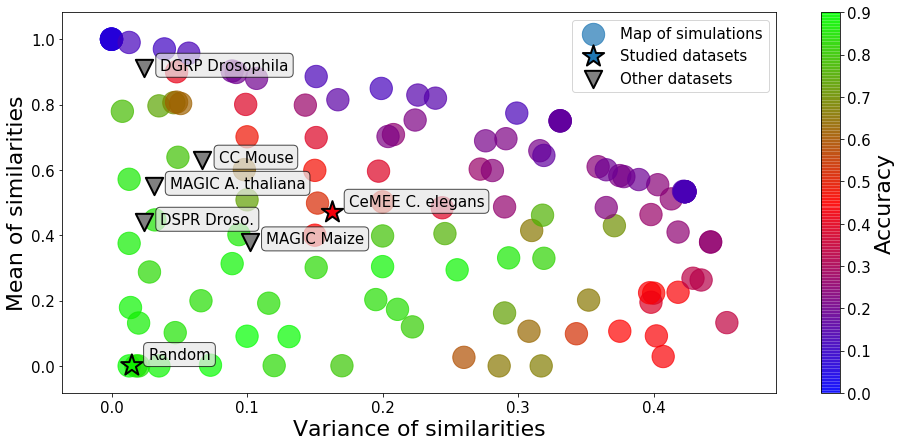

In [20]:
Sim = np.zeros((S_range[::2].shape[0],V_range.shape[0]))
Var = np.zeros((S_range[::2].shape[0],V_range.shape[0]))
k=0
for i in range(0,L_S+1,2) :
    S = S_range[i]
    for j in range(L_V+1) :
        V = V_range[j]
        Sim[i//2,j] = normalized_cross_similarity(F_genotypes[k],n,p)
        Var[i//2,j] = similarity_standard_deviation(F_genotypes[k],n,p)
        k+=1

im, ax = plt.subplots(1,1, figsize = (16,7))
norm = mpl.colors.Normalize(vmin = 0, vmax = 0.9)
s = ax.scatter(Var, Sim, s = 500, c = max_acc, alpha = 0.7, cmap = "brg", norm = norm, label = "Map of simulations")

Var_2 = [0.163,0.015]
Sim_2 = [0.47,0.001]
ax.scatter(Var_2,Sim_2, marker = "*", edgecolors = "black", linewidths = 2, s = 500, c = [0.43,0.87], cmap = "brg", norm = norm, label = "Studied datasets")
lab = ["CeMEE C. elegans", "Random"]
bbox = dict(boxstyle="round", fc="0.9", alpha = 0.7)
for i, txt in enumerate(lab):
    ax.annotate(txt, xy = (Var_2[i], Sim_2[i]), xytext = (Var_2[i]+0.012, Sim_2[i]+0.02), bbox=bbox)

Var_3 = [0.102,0.067,0.031,0.024,0.024]
Sim_3 = [0.38,0.63,0.55,0.91134,0.440]
ax.scatter(Var_3,Sim_3, marker = "v", edgecolors = "black", linewidths = 2, s = 300, c = "Grey", label = "Other datasets")
lab = ["MAGIC Maize", "CC Mouse", "MAGIC A. thaliana", "DGRP Drosophila", "DSPR Droso."]
bbox = dict(boxstyle="round", fc="0.9", alpha = 0.7)
for i, txt in enumerate(lab):
    ax.annotate(txt, xy = (Var_3[i], Sim_3[i]), xytext = (Var_3[i]+0.012, Sim_3[i]-0.005), bbox=bbox)

ax.set(xlabel = "Variance of similarities", ylabel = "Mean of similarities")
plt.colorbar(s, label = "Accuracy")
plt.legend()
plt.savefig("Varying_similarities.svg", transparent = True)
plt.show()

# Similarity and variance of the founders

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, Conv2D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils, plot_model
import pickle
%matplotlib inline

/Users/jeje/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [42]:
def normalized_cross_similarity (array,n,p) :
    A = np.dot(array,array.T)+np.dot(1-array,1-array.T)
    B = A[np.triu_indices(n, k=1)]/p     # Extract the values that are above the diagonal
    return max(0,np.round(np.mean(B),5)*2-1)    # Normalize between 0 and 1

In [44]:
def similarity_standard_deviation(array,n,p):
    A = np.dot(array,array.T)+np.dot(1-array,1-array.T)
    B = A[np.triu_indices(n, k=1)]/p     # Extract the values that are above the diagonal
    return np.round(np.sqrt(np.var(B)),3)

## 37525 SNPs + 16 founders

In [53]:
n = 16    # founders
p = 37525 # nb of SNPs
G = 20    # nb of generations
N = 50    # number recombining individuals in a generation after sampling
I = 50    # nb of itérations

In [54]:
with open("../Recombinations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    geno = pickle.load(handler)
    F_geno = np.array(geno[:n])

F_geno.shape

(16, 37525)

In [55]:
normalized_cross_similarity (F_geno,n,p)

0.46063999999999994

In [56]:
similarity_standard_deviation(F_geno,n,p)

0.161

## 37525 SNPs + 12 founders

In [57]:
n = 12    # founders
p = 37525 # nb of SNPs
G = 20    # nb of generations
N = 100    # number recombining individuals in a generation after sampling
I = 100    # nb of itérations

In [58]:
with open("../Recombinations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    geno = pickle.load(handler)
    F_geno = np.array(geno[:n])

F_geno.shape

(12, 37525)

In [59]:
normalized_cross_similarity (F_geno,n,p)

0.35007999999999995

In [60]:
similarity_standard_deviation(F_geno,n,p)

0.196

## 12035 SNPs + 16 founders

In [61]:
n = 16    # founders
p = 12035 # nb of SNPs
G = 20    # nb of generations
N = 100   # number recombining individuals in a generation after sampling
I = 10    # nb of itérations

In [62]:
with open("../Recombinations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    geno = pickle.load(handler)
    F_geno = np.array(geno[:n])

F_geno.shape

(16, 12035)

In [63]:
normalized_cross_similarity (F_geno,n,p)

0.3577600000000001

In [64]:
similarity_standard_deviation(F_geno,n,p)

0.157

## 12035 SNPs + 12 founders

In [65]:
n = 12    # founders
p = 12035 # nb of SNPs
G = 20    # nb of generations
N = 100    # number recombining individuals in a generation after sampling
I = 100    # nb of itérations

In [66]:
with open("../Recombinations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    geno = pickle.load(handler)
    F_geno = np.array(geno[:n])

F_geno.shape

(12, 12035)

In [67]:
normalized_cross_similarity (F_geno,n,p)

0.24722

In [68]:
similarity_standard_deviation(F_geno,n,p)

0.232

## 1015 SNPs + 16 founders

In [45]:
n = 16    # founders
p = 1015  # nb of SNPs
G = 20    # nb of generations
N = 100   # number recombining individuals in a generation after sampling
I = 100   # nb of itérations

In [46]:
with open("../Recombinations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    geno = pickle.load(handler)
    F_geno = np.array(geno[:n])

F_geno.shape

(16, 1015)

In [47]:
normalized_cross_similarity (F_geno,n,p)

0.4678199999999999

In [48]:
similarity_standard_deviation(F_geno,n,p)

0.163

## 1000 SNPs + 16 founders

In [49]:
n = 16    # founders
p = 1000  # nb of SNPs
G = 20    # nb of generations
N = 100   # number recombining individuals in a generation after sampling
I = 100   # nb of itérations

In [50]:
with open("../Simulations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    geno = pickle.load(handler)
    F_geno = np.array(geno[:n])

F_geno.shape

(16, 1000)

In [51]:
normalized_cross_similarity (F_geno,n,p)

0.0011399999999999189

In [52]:
similarity_standard_deviation(F_geno,n,p)

0.015